In [1]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

In [3]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True,
                                   validation_split=0.2) 

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


train_data = train_datagen.flow_from_directory("seg_train", 
                                               target_size=(150, 150), 
                                               color_mode='rgb',
                                               batch_size=1, 
                                               class_mode='categorical',
                                               shuffle=True,
                                               subset = 'training') 

test_data = train_datagen.flow_from_directory("seg_train", 
                                           target_size=(150, 150), 
                                           color_mode='rgb',
                                           batch_size=1, 
                                           class_mode='categorical',
                                           shuffle=False,
                                           subset = 'validation')

Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


In [4]:
es=tf.keras.callbacks.EarlyStopping(monitor='val_acc',patience=5,restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', factor=0.2,
                              patience=2, min_lr=0.001)

In [5]:
#trian_data=train_datagen.flow_from_directory(directory="seg_train",target_size=(150,150),batch_size=32,shuffle=True,class_mode='categorical')

In [6]:
#test_gen=ImageDataGenerator(rescale=1./255)
#test_data=test_gen.flow_from_directory('seg_test',target_size=(150,150),batch_size=1,shuffle=True)

In [7]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.vgg16.VGG16(include_top=False,input_shape=(150, 150, 3),pooling='avg',weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [8]:
x = layers.Flatten()(resnet_model.output)
x = layers.Dense(250, activation='relu', name='fc1')(x)
x = layers.Dense(100, activation='relu', name='fc2')(x)
x = layers.Dense(4, activation='softmax')(x)
resnet_model = tf.keras.Model(inputs=resnet_model.inputs, outputs=x)

resnet_model.add(layers.Flatten())

resnet_model.add(layers.Dense(512, activation='relu'))
resnet_model.add(layers.BatchNormalization())
resnet_model.add(layers.Dropout(0.2))
resnet_model.add(layers.Dense(4, activation='softmax'))

In [9]:
resnet_model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16_input (InputLayer)     [(None, 150, 150, 3)]     0         
_________________________________________________________________
vgg16 (Model)                (None, 512)               14714688  
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
fc1 (Dense)                  (None, 250)               128250    
_________________________________________________________________
fc2 (Dense)                  (None, 100)               25100     
_________________________________________________________________
dense (Dense)                (None, 4)                 404       
Total params: 14,868,442
Trainable params: 153,754
Non-trainable params: 14,714,688
___________________________________________

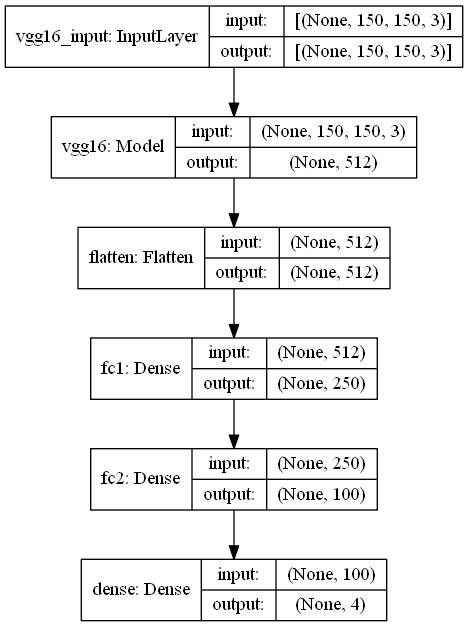

In [10]:
tf.keras.utils.plot_model(resnet_model, show_shapes=True, show_layer_names=True)


In [11]:
resnet_model.compile(optimizer="adam",loss="categorical_crossentropy" ,metrics=['accuracy'])



In [ ]:
history = resnet_model.fit(train_data, validation_data=test_data, epochs=50,verbose=1,batch_size=1,callbacks = [es,reduce_lr])


Epoch 1/50
5121/5121 [==============================] - 78s 15ms/step - loss: 0.9835 - acc: 0.5161 - val_loss: 1.1949 - val_acc: 0.3612
Epoch 2/50
5121/5121 [==============================] - 78s 15ms/step - loss: 0.9020 - acc: 0.5671 - val_loss: 1.1900 - val_acc: 0.4167
Epoch 3/50
5121/5121 [==============================] - 77s 15ms/step - loss: 0.8774 - acc: 0.5835 - val_loss: 1.2442 - val_acc: 0.3526
Epoch 4/50
5121/5121 [==============================] - 78s 15ms/step - loss: 0.8538 - acc: 0.6024 - val_loss: 1.2754 - val_acc: 0.3503
Epoch 5/50
5121/5121 [==============================] - 77s 15ms/step - loss: 0.8357 - acc: 0.6112 - val_loss: 1.4304 - val_acc: 0.2909
Epoch 6/50
5121/5121 [==============================] - 77s 15ms/step - loss: 0.8359 - acc: 0.6184 - val_loss: 1.2416 - val_acc: 0.3792
Epoch 7/50
5112/5121 [============================>.] - ETA: 0s - loss: 0.8226 - acc: 0.6193

In [ ]:
history.history.keys()

In [ ]:
import keras
from matplotlib import pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:

import keras
from matplotlib import pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()